In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import matplotlib.colors as mcolors
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav_synthetic_sources.csv', header=0)

icegrav_coords = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
coordinates = [icegrav_synthetic.x, icegrav_synthetic.y, icegrav_synthetic.u]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 30)]).T

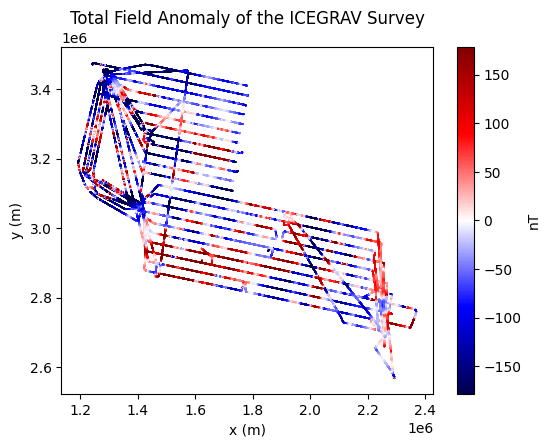

In [4]:
plt.figure(figsize=(6,4.5))
scale_tfa_real = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*icegrav_coords[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale_tfa_real, vmax=scale_tfa_real)
plt.title("Total Field Anomaly of the ICEGRAV Survey")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.show()

In [5]:
grid_spacing = 5e3
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = np.sqrt(sum(c**2 for c in true_b))

In [6]:
# Define a custom colormap similar to the red portion of the seismic colour scheme for the norm of b figures.
colours = [(1, 1, 1), (1, 0.3, 0.3), (1, 0, 0), (0.5, 0, 0)]  # White -> bright light red -> bright red -> dark red
n_bins = 100  
red_cm = mcolors.LinearSegmentedColormap.from_list("white_to_red", colours, N=n_bins)
red_norm = mcolors.Normalize(vmin=0, vmax=vd.maxabs(icegrav_synthetic.bnorm)) # Normalise with the bnorm range

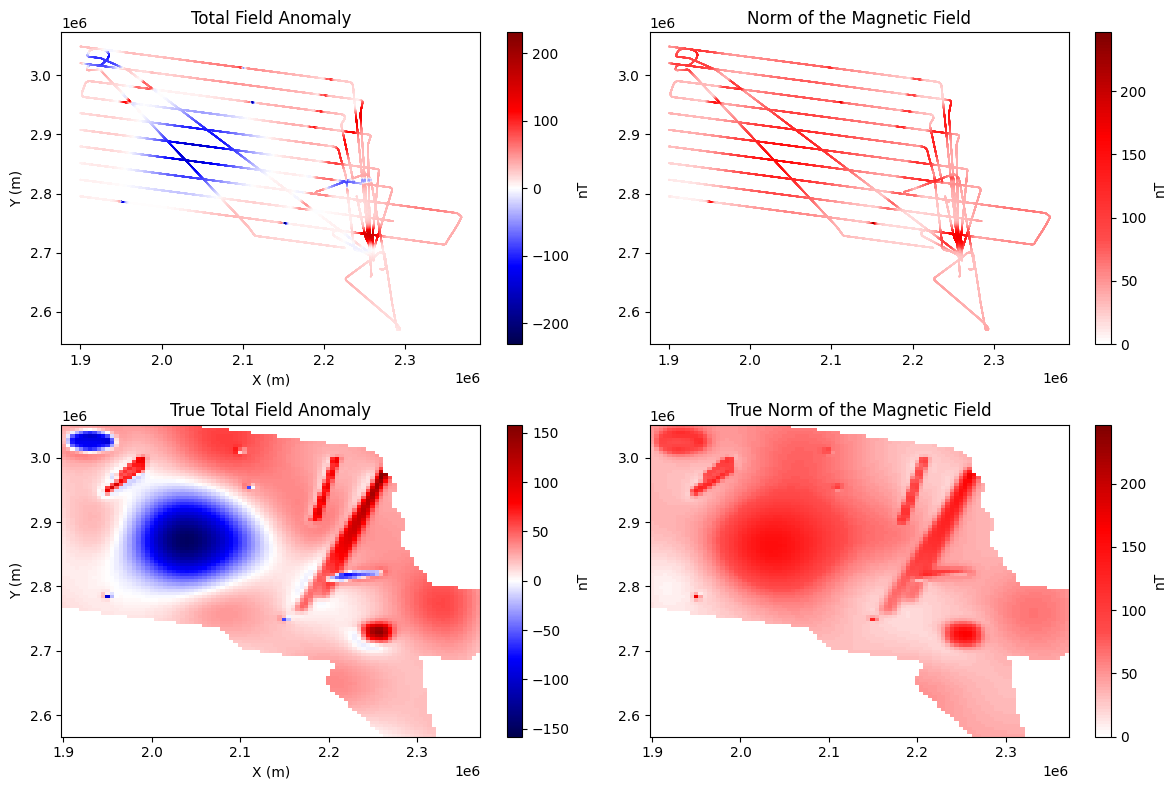

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
scale_tfa_synthetic = vd.maxabs(icegrav_synthetic.tfa)
plot1 = ax[0,0].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,0].set_title("Total Field Anomaly")
ax[0,0].set_xlabel("X (m)")
ax[0,0].set_ylabel("Y (m)")
fig.colorbar(plot1, ax=ax[0,0], label="nT")

scale_bnorm_synthetic = vd.maxabs(icegrav_synthetic.bnorm)
plot2 = ax[0,1].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.bnorm,
    cmap=red_cm,
    s=0.01,
    norm=red_norm,
)
ax[0,1].set_title("Norm of the Magnetic Field")
fig.colorbar(plot2, ax=ax[0,1], label="nT")

scale_true_tfa = vd.maxabs(true_tfa)
plot3 = ax[1, 0].pcolormesh(
    *grid_coordinates[:2],
    true_tfa,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 0].set_title("True Total Field Anomaly")
ax[1, 0].set_xlabel("X (m)")
ax[1, 0].set_ylabel("Y (m)")
fig.colorbar(plot3, ax=ax[1, 0], label="nT")

plot4 = ax[1, 1].pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap=red_cm,
    norm=red_norm,
)
ax[1, 1].set_title("True Norm of the Magnetic Field")
fig.colorbar(plot4, ax=ax[1, 1], label="nT")

fig.tight_layout()
fig.show()

# One layer GB EQS

In [8]:
window_size = 250e3
# dampings_1layer = [1e1, 1e2, 1e3]
# depths_1layer = [30e3, 40e3, 50e3]
dampings_1layer = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
depths_1layer = [20e3, 25e3, 30e3, 35e3, 40e3, 45e3, 50e3]

parameter_sets_1layer = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_1layer, depths_1layer)
]
print("Number of combinations:", len(parameter_sets_1layer))

Number of combinations: 42


In [9]:
%%time
kfold = vd.BlockKFold(
    spacing=30e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_1layer = []
damping_1layer = []
source_depth_1layer = []
for parameters in parameter_sets_1layer:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
        random_state=0, 
        block_size=grid_spacing,
        window_size=window_size,
        **parameters,
    )
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            icegrav_synthetic.tfa[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(icegrav_synthetic.tfa[test] - predicted))
    scores_1layer.append(np.mean(tmp))
    damping_1layer.append(parameters['damping'])
    source_depth_1layer.append(parameters['depth'])

{'damping': 1.0, 'depth': 20000.0}
{'damping': 1.0, 'depth': 25000.0}
{'damping': 1.0, 'depth': 30000.0}
{'damping': 1.0, 'depth': 35000.0}
{'damping': 1.0, 'depth': 40000.0}
{'damping': 1.0, 'depth': 45000.0}
{'damping': 1.0, 'depth': 50000.0}
{'damping': 10.0, 'depth': 20000.0}
{'damping': 10.0, 'depth': 25000.0}
{'damping': 10.0, 'depth': 30000.0}
{'damping': 10.0, 'depth': 35000.0}
{'damping': 10.0, 'depth': 40000.0}
{'damping': 10.0, 'depth': 45000.0}
{'damping': 10.0, 'depth': 50000.0}
{'damping': 100.0, 'depth': 20000.0}
{'damping': 100.0, 'depth': 25000.0}
{'damping': 100.0, 'depth': 30000.0}
{'damping': 100.0, 'depth': 35000.0}
{'damping': 100.0, 'depth': 40000.0}
{'damping': 100.0, 'depth': 45000.0}
{'damping': 100.0, 'depth': 50000.0}
{'damping': 1000.0, 'depth': 20000.0}
{'damping': 1000.0, 'depth': 25000.0}
{'damping': 1000.0, 'depth': 30000.0}
{'damping': 1000.0, 'depth': 35000.0}
{'damping': 1000.0, 'depth': 40000.0}
{'damping': 1000.0, 'depth': 45000.0}
{'damping': 1000

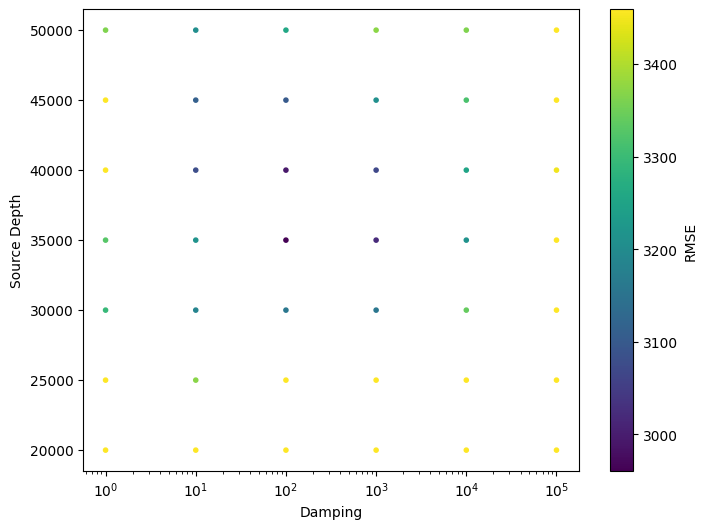

{'damping': 100.0, 'depth': 35000.0}

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(
    damping_1layer,
    source_depth_1layer,
    c=scores_1layer,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_1layer,60),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

best_1layer = np.argmin(scores_1layer)
parameter_sets_1layer[best_1layer]

In [11]:
%%time
eqs_shallow_1layer = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    **parameter_sets_1layer[best_1layer],
    repeat=2,
)
eqs_shallow_1layer.fit(coordinates, icegrav_synthetic.tfa, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -47114.9
window size: 250000.0
CPU times: user 1min 18s, sys: 21.2 s, total: 1min 39s
Wall time: 7.67 s


In [12]:
tfa_predicted_1layer = eqs.total_field_anomaly(
    eqs_shallow_1layer.predict(coordinates),
    field_direction
)
error_tfa_1layer = icegrav_synthetic.tfa - tfa_predicted_1layer
rmse_tfa_1layer = np.sqrt(np.nanmean((error_tfa_1layer)**2))

predicted_b_grid_1layer = eqs_shallow_1layer.predict(grid_coords_masked)
predicted_tfa_grid_1layer = eqs.total_field_anomaly(predicted_b_grid_1layer, field_direction)
error_tfa_grid_1layer = true_tfa - predicted_tfa_grid_1layer
rmse_tfa_grid_1layer = np.sqrt(np.nanmean((error_tfa_grid_1layer)**2))

predicted_bnorm_grid_1layer = np.sqrt(sum(c**2 for c in predicted_b_grid_1layer))
error_bnorm_grid_1layer = true_bnorm - predicted_bnorm_grid_1layer
rmse_bnorm_grid_1layer = np.sqrt(np.nanmean((error_bnorm_grid_1layer)**2))

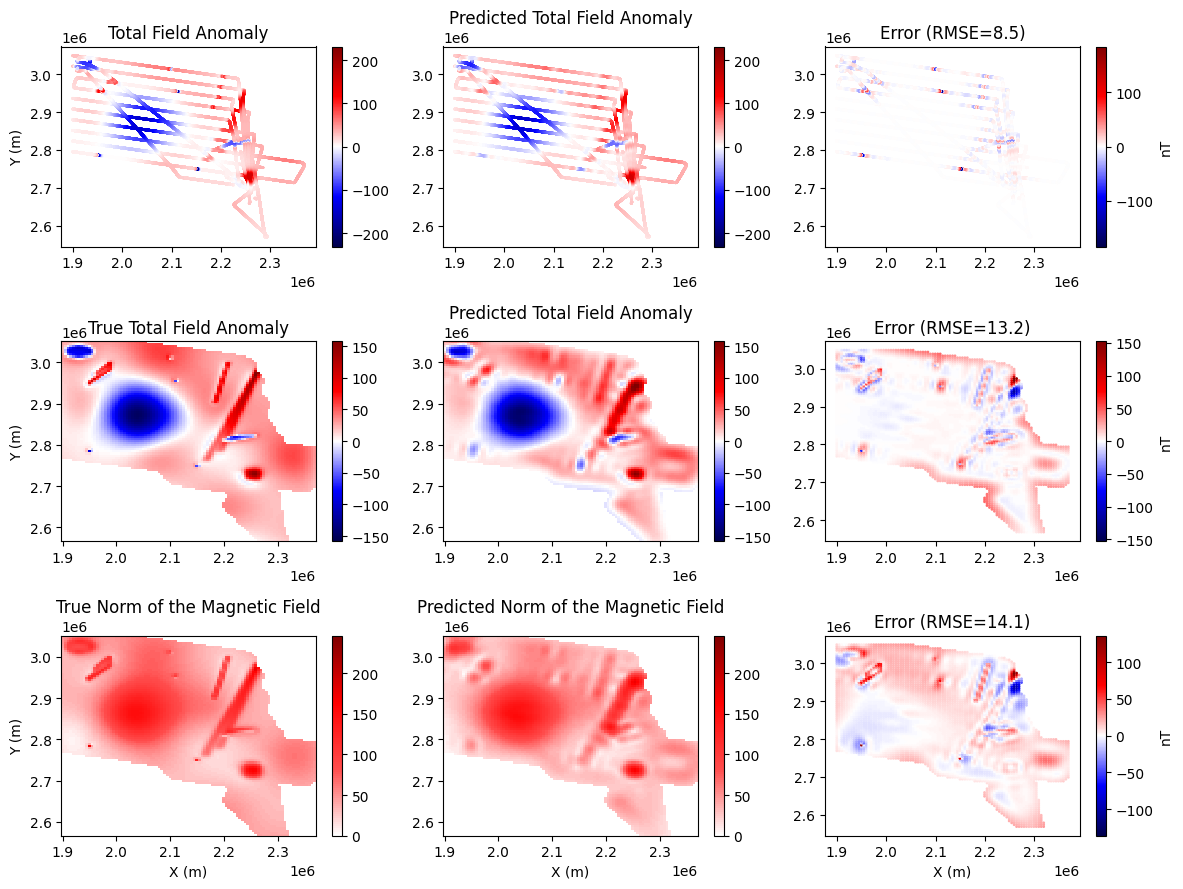

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(12,9))
plot1 = ax[0,0].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,0].set_title("Total Field Anomaly")
ax[0,0].set_ylabel("Y (m)")
fig.colorbar(plot1, ax=ax[0,0])

scale_tfa_1layer = vd.maxabs(tfa_predicted_1layer)
plot2 = ax[0,1].scatter(
    *coordinates[:2],
    c=tfa_predicted_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot2, ax=ax[0,1])

scale_error_tfa_1layer = vd.maxabs(error_tfa_1layer)
plot3 = ax[0,2].scatter(
    *coordinates[:2],
    c=error_tfa_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa_1layer,
    vmax=scale_error_tfa_1layer,
)
ax[0,2].set_title('Error (RMSE={})'.format(round(rmse_tfa_1layer,1)))
fig.colorbar(plot3, ax=ax[0,2], label="nT")

plot4 = ax[1, 0].pcolormesh(
    *grid_coordinates[:2],
    true_tfa,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 0].set_title("True Total Field Anomaly")
ax[1, 0].set_ylabel("Y (m)")
fig.colorbar(plot4, ax=ax[1, 0])

plot5 = ax[1, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_tfa_grid_1layer,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot5, ax=ax[1, 1])

scale_error_tfa_grid_1layer = vd.maxabs(error_tfa_grid_1layer)
plot6 = ax[1,2].scatter(
    *grid_coordinates[:2],
    c=error_tfa_grid_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa_grid_1layer,
    vmax=scale_error_tfa_grid_1layer,
)
ax[1,2].set_title('Error (RMSE={})'.format(round(rmse_tfa_grid_1layer,1)))
fig.colorbar(plot6, ax=ax[1,2], label="nT")

plot7 = ax[2, 0].pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 0].set_title("True Norm of the Magnetic Field")
ax[2, 0].set_xlabel("X (m)")
ax[2, 0].set_ylabel("Y (m)")
fig.colorbar(plot7, ax=ax[2, 0])

plot8 = ax[2, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_bnorm_grid_1layer,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 1].set_title("Predicted Norm of the Magnetic Field")
ax[2, 1].set_xlabel("X (m)")
fig.colorbar(plot8, ax=ax[2, 1])

scale_error_bnorm_grid_1layer = vd.maxabs(error_bnorm_grid_1layer)
plot9 = ax[2,2].scatter(
    *grid_coordinates[:2],
    c=error_bnorm_grid_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_error_bnorm_grid_1layer,
    vmax=scale_error_bnorm_grid_1layer,
)
ax[2,2].set_title('Error (RMSE={})'.format(round(rmse_bnorm_grid_1layer,1)))
ax[2, 2].set_xlabel("X (m)")
fig.colorbar(plot9, ax=ax[2, 2], label="nT")

fig.tight_layout()
fig.show()

# 2 layer EQS

## Fit deep sources

In [14]:
block_spacing = 25e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.2)),
    drop_coords=False
)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

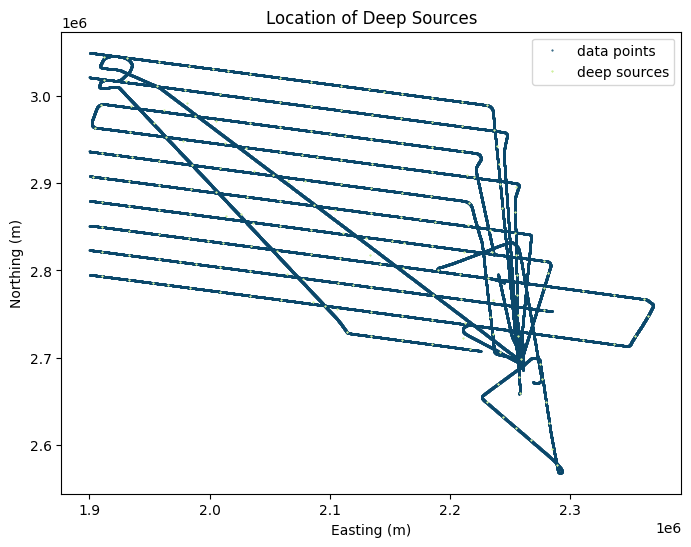

In [15]:
plt.figure(figsize=(8,6))
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], "*", color="#cff09e", markersize=1, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

In [16]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
dampings_deep = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
# depths_deep_eqs = [spacing*3, spacing*3.5, spacing*4]
# dampings_deep_eqs = [1e1, 1e2, 1e3]

In [17]:
parameter_sets_deep = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep, depths_deep)
]
print("Number of combinations:", len(parameter_sets_deep))

Number of combinations: 48


In [18]:
%%time
kfold = vd.BlockKFold(
    spacing=100e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    # print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

CPU times: user 8min 12s, sys: 3min 58s, total: 12min 10s
Wall time: 20.4 s


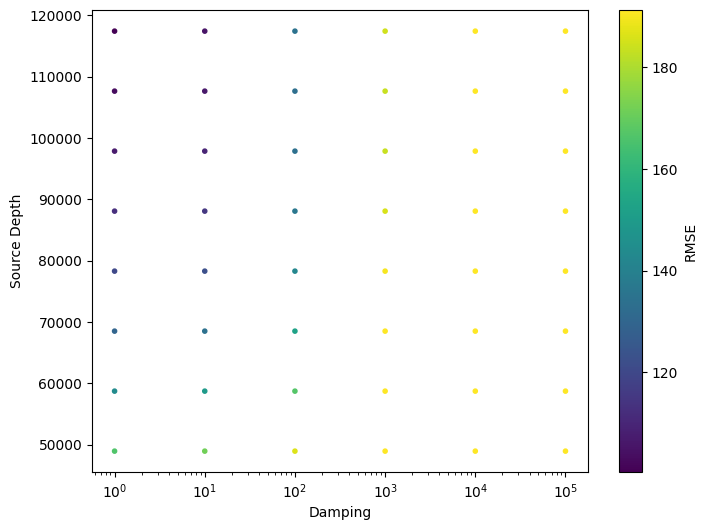

{'damping': 1.0, 'depth': 117422.42366088359}

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(
    damping_deep,
    source_depth_deep,
    c=scores_deep,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_deep,60),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

best_deep = np.argmin(scores_deep)
parameter_sets_deep[best_deep]

In [20]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

tfa_deep_grid = eqs.total_field_anomaly(eqs_deep.predict(grid_coords_masked), field_direction)
tfa_residuals_grid = true_tfa - tfa_deep_grid

source height: -114537.9736608836
CPU times: user 2.7 s, sys: 854 ms, total: 3.56 s
Wall time: 102 ms


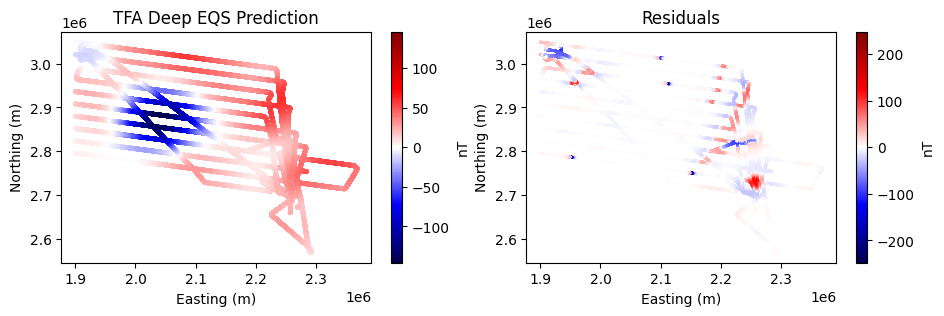

In [21]:
plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
scale_tfa_deep = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale_tfa_deep, vmax=scale_tfa_deep)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale_tfa_residuals = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale_tfa_residuals, vmax=scale_tfa_residuals)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

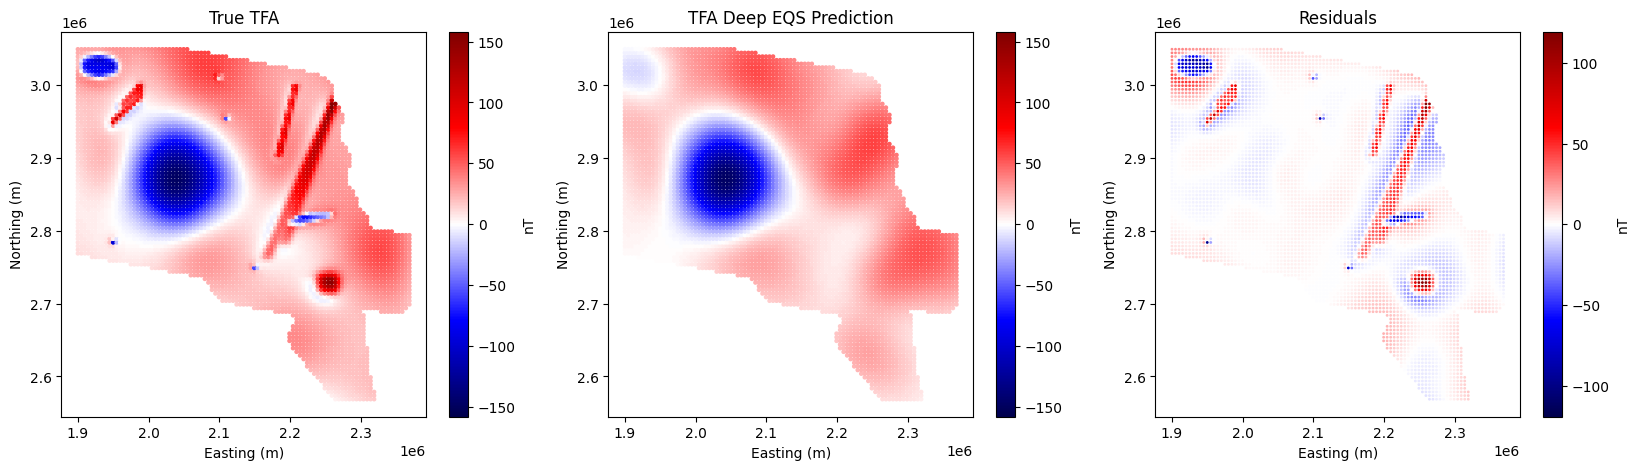

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(*grid_coords_masked[:2], c=true_tfa, cmap="seismic", s=5, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
# scale = vd.maxabs(tfa_deep_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_deep_grid, cmap="seismic", s=5, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,3)
scale_tfa_residual_grid = vd.maxabs(tfa_residuals_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_residuals_grid, cmap="seismic", s=1, vmin=-scale_tfa_residual_grid, vmax=scale_tfa_residual_grid)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [23]:
dampings_shallow = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
depths_shallow = [15e3, 16e3, 17e3, 18e3, 19e3, 20e3]

parameter_sets_shallow = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow, depths_shallow)
]
print("Number of combinations:", len(parameter_sets_shallow))

Number of combinations: 36


In [24]:
%%time
kfold = vd.BlockKFold(
    spacing=30e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores_shallow.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 1.0, 'depth': 15000.0}
{'damping': 1.0, 'depth': 16000.0}
{'damping': 1.0, 'depth': 17000.0}
{'damping': 1.0, 'depth': 18000.0}
{'damping': 1.0, 'depth': 19000.0}
{'damping': 1.0, 'depth': 20000.0}
{'damping': 10.0, 'depth': 15000.0}
{'damping': 10.0, 'depth': 16000.0}
{'damping': 10.0, 'depth': 17000.0}
{'damping': 10.0, 'depth': 18000.0}
{'damping': 10.0, 'depth': 19000.0}
{'damping': 10.0, 'depth': 20000.0}
{'damping': 100.0, 'depth': 15000.0}
{'damping': 100.0, 'depth': 16000.0}
{'damping': 100.0, 'depth': 17000.0}
{'damping': 100.0, 'depth': 18000.0}
{'damping': 100.0, 'depth': 19000.0}
{'damping': 100.0, 'depth': 20000.0}
{'damping': 1000.0, 'depth': 15000.0}
{'damping': 1000.0, 'depth': 16000.0}
{'damping': 1000.0, 'depth': 17000.0}
{'damping': 1000.0, 'depth': 18000.0}
{'damping': 1000.0, 'depth': 19000.0}
{'damping': 1000.0, 'depth': 20000.0}
{'damping': 10000.0, 'depth': 15000.0}
{'damping': 10000.0, 'depth': 16000.0}
{'damping': 10000.0, 'depth': 17000.0}
{'dampi

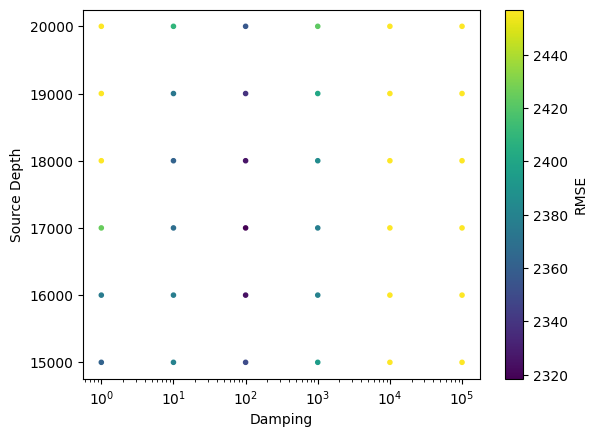

{'damping': 100.0, 'depth': 17000.0}

In [25]:
plt.figure()
plt.scatter(
    damping_shallow,
    source_depth_shallow,
    c=scores_shallow,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_shallow,60),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

best_shallow = np.argmin(scores_shallow)
parameter_sets_shallow[best_shallow]

In [26]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 1min 19s, sys: 21.4 s, total: 1min 41s
Wall time: 7.72 s


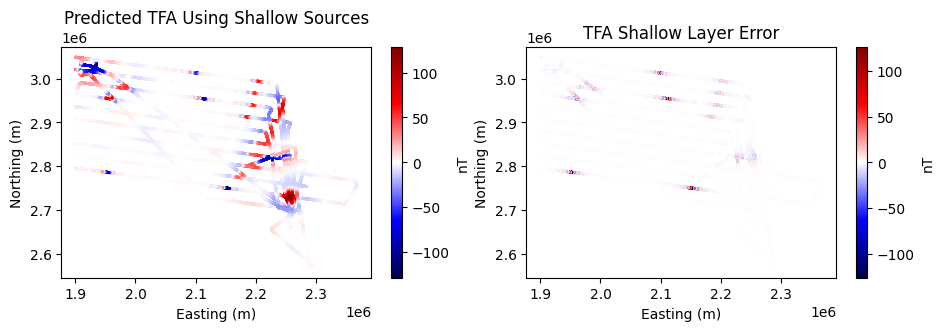

In [27]:
tfa_shallow_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(11,3))
scale_shallow_predicted = vd.maxabs(tfa_shallow_predicted)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
error_shallow_predicted = tfa_residuals - tfa_shallow_predicted
scale_error_shallow_predicted = vd.maxabs(error_shallow_predicted)
plt.scatter(*coordinates[:2], c=error_shallow_predicted, cmap="seismic", s=1, vmin=-scale_error_shallow_predicted, vmax=scale_error_shallow_predicted)
plt.title("TFA Shallow Layer Error")
plt.xlabel( "Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Dual Layer Prediction

In [28]:
predicted_tfa = eqs.total_field_anomaly(
    (eqs_deep.predict(coordinates) + eqs_shallow.predict(coordinates)),
    field_direction,
)
error_tfa = icegrav_synthetic.tfa - predicted_tfa
rmse_tfa = np.sqrt(np.nanmean((error_tfa)**2))

predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
error_tfa_grid = true_tfa - predicted_tfa_grid
rmse_tfa_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))

predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))
error_bnorm_grid = true_bnorm - predicted_bnorm_grid
rmse_bnorm_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))

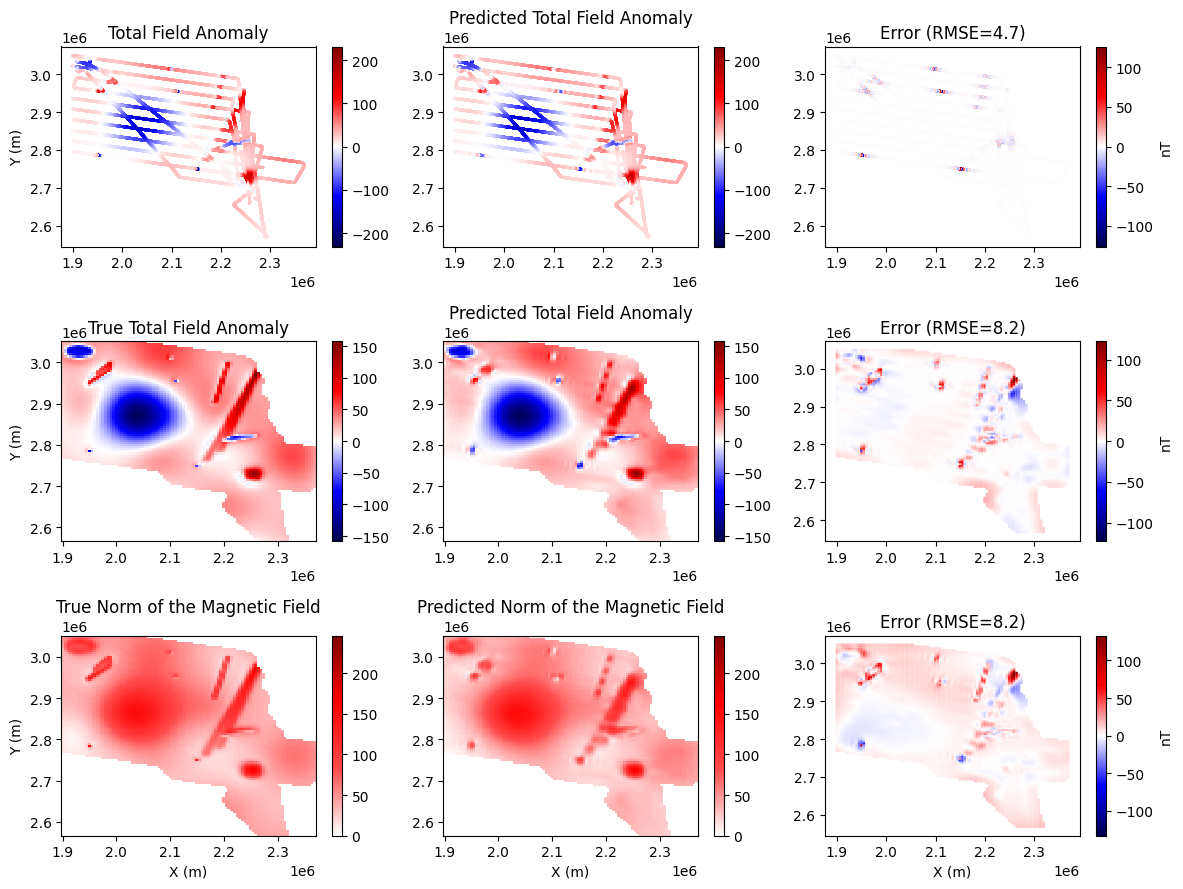

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(12,9))
plot1 = ax[0,0].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,0].set_title("Total Field Anomaly")
ax[0,0].set_ylabel("Y (m)")
fig.colorbar(plot1, ax=ax[0,0])

plot2 = ax[0,1].scatter(
    *coordinates[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot2, ax=ax[0,1])

scale_error_tfa = vd.maxabs(error_tfa)
plot3 = ax[0,2].scatter(
    *coordinates[:2],
    c=error_tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
ax[0,2].set_title('Error (RMSE={})'.format(round(rmse_tfa,1)))
fig.colorbar(plot3, ax=ax[0,2], label="nT")

plot4 = ax[1, 0].pcolormesh(
    *grid_coordinates[:2],
    true_tfa,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 0].set_title("True Total Field Anomaly")
ax[1, 0].set_ylabel("Y (m)")
fig.colorbar(plot4, ax=ax[1, 0])

plot5 = ax[1, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_tfa_grid,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot5, ax=ax[1, 1])

scale_error_tfa_grid = vd.maxabs(error_tfa_grid)
plot6 = ax[1,2].scatter(
    *grid_coordinates[:2],
    c=error_tfa_grid,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa_grid,
    vmax=scale_error_tfa_grid,
)
ax[1,2].set_title('Error (RMSE={})'.format(round(rmse_tfa_grid,1)))
fig.colorbar(plot6, ax=ax[1,2], label="nT")

plot7 = ax[2, 0].pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 0].set_title("True Norm of the Magnetic Field")
ax[2, 0].set_xlabel("X (m)")
ax[2, 0].set_ylabel("Y (m)")
fig.colorbar(plot7, ax=ax[2, 0])

plot8 = ax[2, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_bnorm_grid,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 1].set_title("Predicted Norm of the Magnetic Field")
ax[2, 1].set_xlabel("X (m)")
fig.colorbar(plot8, ax=ax[2, 1])

scale_error_bnorm_grid = vd.maxabs(error_bnorm_grid)
plot9 = ax[2,2].scatter(
    *grid_coordinates[:2],
    c=error_bnorm_grid,
    cmap="seismic",
    s=1,
    vmin=-scale_error_bnorm_grid,
    vmax=scale_error_bnorm_grid,
)
ax[2,2].set_title('Error (RMSE={})'.format(round(rmse_bnorm_grid,1)))
ax[2, 2].set_xlabel("X (m)")
fig.colorbar(plot9, ax=ax[2, 2], label="nT")

fig.tight_layout()
fig.show()

## Figures for paper

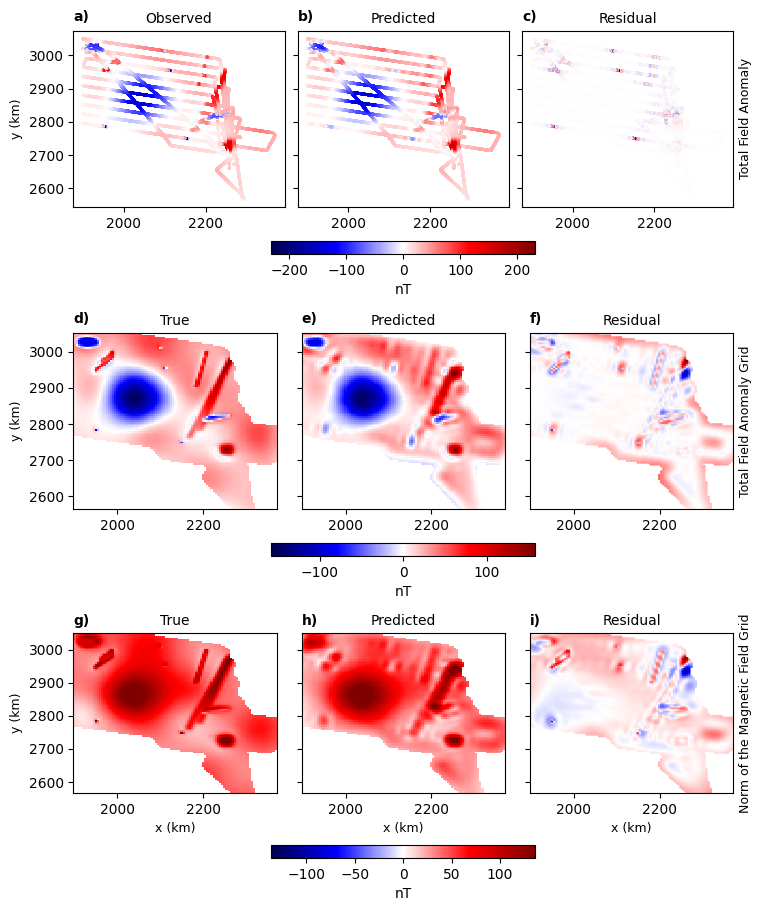

In [108]:
coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

plot_config = {
    "row1": {
        "titles": ['Observed', 'Predicted', 'Residual'],
        "labels": ['a)', 'b)', 'c)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['scatter', 'scatter', 'scatter'],
        "data": [icegrav_synthetic.tfa, tfa_predicted_1layer, error_tfa_1layer],
        "coords": [coordinates_km] * 3,
    },
    "row2": {
        "titles": ['True', 'Predicted', 'Residual'],
        "labels": ['d)', 'e)', 'f)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly Grid'],
        "scales": [scale_true_tfa] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_tfa, predicted_tfa_grid_1layer, error_tfa_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
    },
    "row3": {
        "titles": ['True', 'Predicted', 'Residual'],
        "labels": ['g)', 'h)', 'i)'],
        "ylabels": ['y (km)', '', 'Norm of the Magnetic Field Grid'],
        "scales": [scale_error_bnorm_grid_1layer] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_bnorm, predicted_bnorm_grid_1layer, error_bnorm_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
    }
}

fig = plt.figure(figsize=(7.5, 9), layout="constrained")
figures = fig.subfigures(nrows=3, ncols=1)

for row_idx, (row_key, row_config) in enumerate(plot_config.items()):
    ax = figures[row_idx].subplots(1, 3, sharex=True, sharey=True)
    for col_idx, (title, label, ylabel, scale, plot_type, data, coords) in enumerate(zip(
        row_config["titles"], row_config["labels"], row_config["ylabels"],
        row_config["scales"], row_config["plot_types"], row_config["data"], row_config["coords"]
    )):
        if plot_type == 'scatter':
            plot = ax[col_idx].scatter(
                *coords[:2],
                c=data,
                cmap="seismic",
                s=1,
                vmin=-scale,
                vmax=scale,
            )
        elif plot_type == 'pcolormesh':
            plot = ax[col_idx].pcolormesh(
                *coords[:2],
                data,
                cmap="seismic",
                vmin=-scale,
                vmax=scale,
            )
        ax[col_idx].set_title(title, fontsize=10)
        
        if label in ['c)', 'f)', 'i)']:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)
            ax[col_idx].yaxis.set_label_position('right')
        else:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)

        if label in ['g)', 'h)', 'i)']:
            ax[col_idx].set_xlabel("x (km)", fontsize=9)
            
        ax[col_idx].text(0.0, 1.12, label, transform=ax[col_idx].transAxes, weight='bold', fontsize=10, va='top')     
            
    fig.colorbar(plot, ax=ax, orientation="horizontal", label='nT', pad=0.05, shrink=0.4)

plt.show()

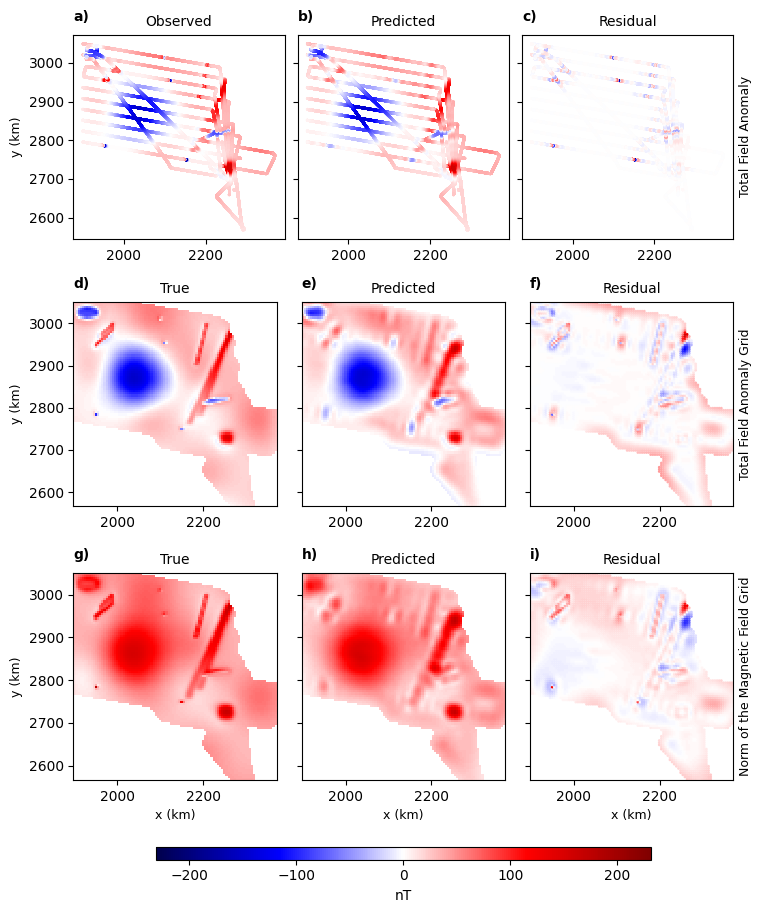

In [124]:
coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

plot_config = {
    "row1": {
        "titles": ['Observed', 'Predicted', 'Residual'],
        "labels": ['a)', 'b)', 'c)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['scatter', 'scatter', 'scatter'],
        "data": [icegrav_synthetic.tfa, tfa_predicted_1layer, error_tfa_1layer],
        "coords": [coordinates_km] * 3,
    },
    "row2": {
        "titles": ['True', 'Predicted', 'Residual'],
        "labels": ['d)', 'e)', 'f)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly Grid'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_tfa, predicted_tfa_grid_1layer, error_tfa_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
    },
    "row3": {
        "titles": ['True', 'Predicted', 'Residual'],
        "labels": ['g)', 'h)', 'i)'],
        "ylabels": ['y (km)', '', 'Norm of the Magnetic Field Grid'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_bnorm, predicted_bnorm_grid_1layer, error_bnorm_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
    }
}

fig = plt.figure(figsize=(7.5, 9), layout="constrained")
figures = fig.subfigures(nrows=3, ncols=1, height_ratios=[1, 1, 1.4])

for row_idx, (row_key, row_config) in enumerate(plot_config.items()):
    ax = figures[row_idx].subplots(1, 3, sharex=True, sharey=True)
    for col_idx, (title, label, ylabel, scale, plot_type, data, coords) in enumerate(zip(
        row_config["titles"], row_config["labels"], row_config["ylabels"],
        row_config["scales"], row_config["plot_types"], row_config["data"], row_config["coords"]
    )):
        if plot_type == 'scatter':
            plot = ax[col_idx].scatter(
                *coords[:2],
                c=data,
                cmap="seismic",
                s=1,
                vmin=-scale,
                vmax=scale,
            )
        elif plot_type == 'pcolormesh':
            plot = ax[col_idx].pcolormesh(
                *coords[:2],
                data,
                cmap="seismic",
                vmin=-scale,
                vmax=scale,
            )
        ax[col_idx].set_title(title, fontsize=10)
        
        if label in ['c)', 'f)', 'i)']:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)
            ax[col_idx].yaxis.set_label_position('right')
        else:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)

        if label in ['g)', 'h)', 'i)']:
            ax[col_idx].set_xlabel("x (km)", fontsize=9)
            
        ax[col_idx].text(0.0, 1.12, label, transform=ax[col_idx].transAxes, weight='bold', fontsize=10, va='top')     
            
fig.colorbar(plot, ax=figures[2].axes, orientation="horizontal", label='nT', pad=0.1, shrink=0.75, aspect=40)

plt.show()

In [155]:
from matplotlib.ticker import MaxNLocator

coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

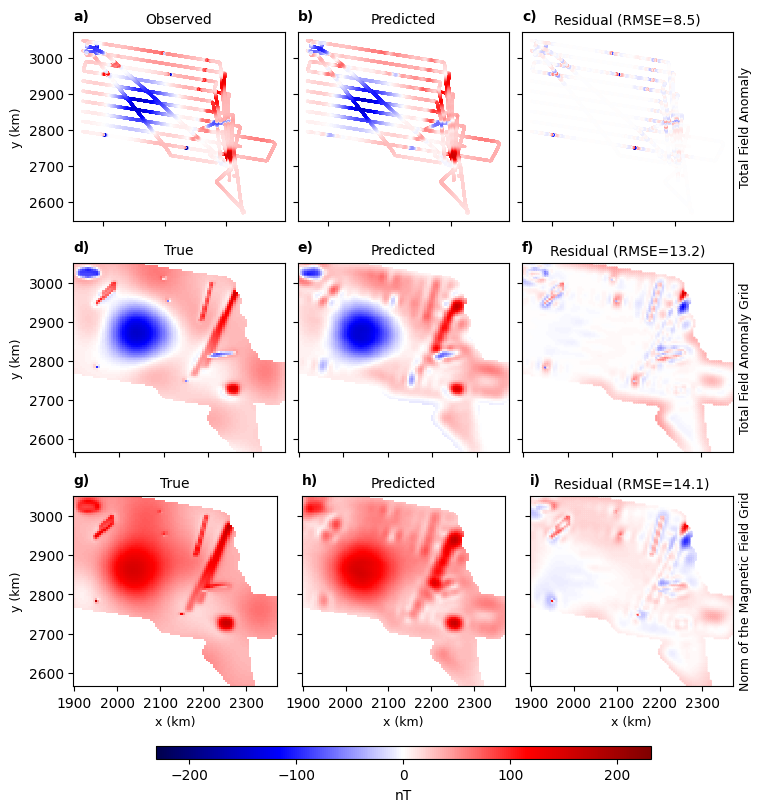

In [156]:
plot_config = {
    "row1": {
        "titles": ['Observed', 'Predicted', 'Residual (RMSE={})'.format(round(rmse_tfa_1layer, 1))],
        "labels": ['a)', 'b)', 'c)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['scatter', 'scatter', 'scatter'],
        "data": [icegrav_synthetic.tfa, tfa_predicted_1layer, error_tfa_1layer],
        "coords": [coordinates_km] * 3,
    },
    "row2": {
        "titles": ['True', 'Predicted', 'Residual (RMSE={})'.format(round(rmse_tfa_grid_1layer, 1))],
        "labels": ['d)', 'e)', 'f)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly Grid'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_tfa, predicted_tfa_grid_1layer, error_tfa_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
    },
    "row3": {
        "titles": ['True', 'Predicted', 'Residual (RMSE={})'.format(round(rmse_bnorm_grid_1layer, 1))],
        "labels": ['g)', 'h)', 'i)'],
        "ylabels": ['y (km)', '', 'Norm of the Magnetic Field Grid'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_bnorm, predicted_bnorm_grid_1layer, error_bnorm_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
    }
}

fig = plt.figure(figsize=(7.5, 8), layout="constrained")
figures = fig.subfigures(nrows=3, ncols=1, height_ratios=[1, 1, 1.5])

for row_idx, (row_key, row_config) in enumerate(plot_config.items()):
    ax = figures[row_idx].subplots(1, 3, sharex=True, sharey=True)
    for col_idx, (title, label, ylabel, scale, plot_type, data, coords) in enumerate(zip(
        row_config["titles"], row_config["labels"], row_config["ylabels"],
        row_config["scales"], row_config["plot_types"], row_config["data"], row_config["coords"]
    )):
        if plot_type == 'scatter':
            plot = ax[col_idx].scatter(
                *coords[:2],
                c=data,
                cmap="seismic",
                s=1,
                vmin=-scale,
                vmax=scale,
            )
        elif plot_type == 'pcolormesh':
            plot = ax[col_idx].pcolormesh(
                *coords[:2],
                data,
                cmap="seismic",
                vmin=-scale,
                vmax=scale,
            )
        ax[col_idx].set_title(title, fontsize=10)
        
        if label in ['c)', 'f)', 'i)']:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)
            ax[col_idx].yaxis.set_label_position('right')
        else:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)

        if label in ['g)', 'h)', 'i)']:
            ax[col_idx].set_xlabel("x (km)", fontsize=9)
            
        ax[col_idx].text(0.0, 1.12, label, transform=ax[col_idx].transAxes, weight='bold', fontsize=10, va='top')
    
        ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))  # Set number of x-ticks
        if row_idx != 2:
            for col in ax:
                col.set_xticklabels([])  # Hide x-tick labels for rows 1 and 2
                col.set_xticks(ax[2].get_xticks())  # Hide x-tick labels for rows 1 and 2
        else:
            ax[0].set_xticks(ax[2].get_xticks()) 
            ax[0].set_xticklabels(ax[2].get_xticklabels())
            
fig.colorbar(plot, ax=figures[2].axes, orientation="horizontal", label='nT', pad=0.08, shrink=0.75, aspect=40)

plt.show()

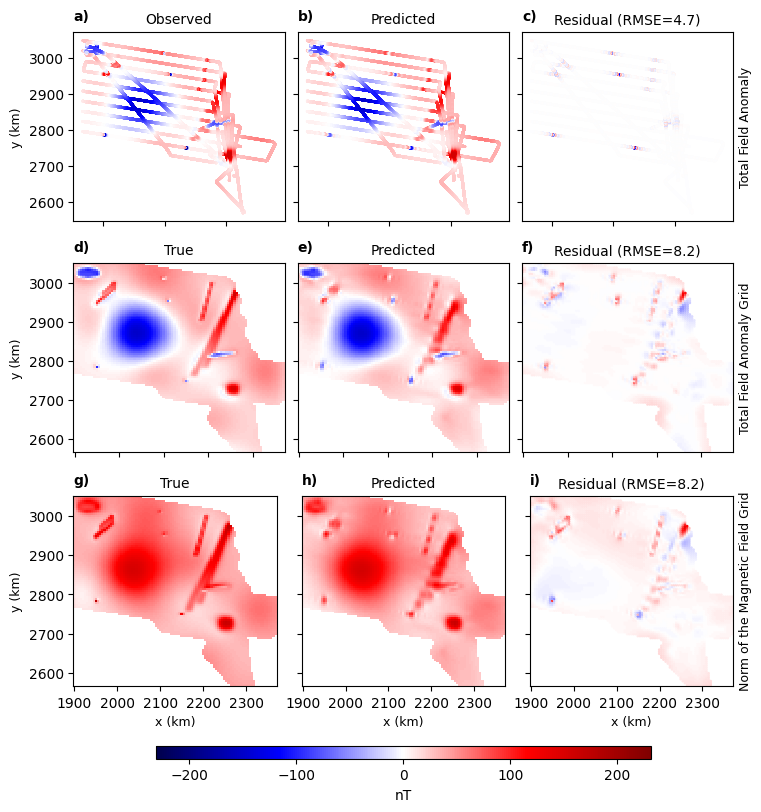

In [157]:
plot_config = {
    "row1": {
        "titles": ['Observed', 'Predicted', 'Residual (RMSE={})'.format(round(rmse_tfa, 1))],
        "labels": ['a)', 'b)', 'c)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['scatter', 'scatter', 'scatter'],
        "data": [icegrav_synthetic.tfa, predicted_tfa, error_tfa],
        "coords": [coordinates_km] * 3,
    },
    "row2": {
        "titles": ['True', 'Predicted', 'Residual (RMSE={})'.format(round(rmse_tfa_grid, 1))],
        "labels": ['d)', 'e)', 'f)'],
        "ylabels": ['y (km)', '', 'Total Field Anomaly Grid'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_tfa, predicted_tfa_grid, error_tfa_grid],
        "coords": [grid_coordinates_km] * 3,
    },
    "row3": {
        "titles": ['True', 'Predicted', 'Residual (RMSE={})'.format(round(rmse_bnorm_grid, 1))],
        "labels": ['g)', 'h)', 'i)'],
        "ylabels": ['y (km)', '', 'Norm of the Magnetic Field Grid'],
        "scales": [scale_tfa_synthetic] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "data": [true_bnorm, predicted_bnorm_grid, error_bnorm_grid],
        "coords": [grid_coordinates_km] * 3,
    }
}

fig = plt.figure(figsize=(7.5, 8), layout="constrained")
figures = fig.subfigures(nrows=3, ncols=1, height_ratios=[1, 1, 1.5])

for row_idx, (row_key, row_config) in enumerate(plot_config.items()):
    ax = figures[row_idx].subplots(1, 3, sharex=True, sharey=True)
    for col_idx, (title, label, ylabel, scale, plot_type, data, coords) in enumerate(zip(
        row_config["titles"], row_config["labels"], row_config["ylabels"],
        row_config["scales"], row_config["plot_types"], row_config["data"], row_config["coords"]
    )):
        if plot_type == 'scatter':
            plot = ax[col_idx].scatter(
                *coords[:2],
                c=data,
                cmap="seismic",
                s=1,
                vmin=-scale,
                vmax=scale,
            )
        elif plot_type == 'pcolormesh':
            plot = ax[col_idx].pcolormesh(
                *coords[:2],
                data,
                cmap="seismic",
                vmin=-scale,
                vmax=scale,
            )
        ax[col_idx].set_title(title, fontsize=10)
        
        if label in ['c)', 'f)', 'i)']:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)
            ax[col_idx].yaxis.set_label_position('right')
        else:
            ax[col_idx].set_ylabel(ylabel, fontsize=9)

        if label in ['g)', 'h)', 'i)']:
            ax[col_idx].set_xlabel("x (km)", fontsize=9)
            
        ax[col_idx].text(0.0, 1.12, label, transform=ax[col_idx].transAxes, weight='bold', fontsize=10, va='top')
    
        ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))  # Set number of x-ticks
        if row_idx != 2:
            for col in ax:
                col.set_xticklabels([])  # Hide x-tick labels for rows 1 and 2
                col.set_xticks(ax[2].get_xticks())  # Hide x-tick labels for rows 1 and 2
        else:
            ax[0].set_xticks(ax[2].get_xticks()) 
            ax[0].set_xticklabels(ax[2].get_xticklabels())
            
fig.colorbar(plot, ax=figures[2].axes, orientation="horizontal", label='nT', pad=0.08, shrink=0.75, aspect=40)

plt.show()